### Activamos multi-threading en VSCode con JupyterNotebook

+ [https://docs.julialang.org/en/v1/manual/multi-threading/](https://docs.julialang.org/en/v1/manual/multi-threading/)
+ [https://enccs.github.io/Julia-for-HPC/multithreading/](https://enccs.github.io/Julia-for-HPC/multithreading/)
+ [https://stackoverflow.com/questions/71596187/changing-threads-in-settings-json-of-vs-code-for-julias-jupyter-notebooks](https://stackoverflow.com/questions/71596187/changing-threads-in-settings-json-of-vs-code-for-julias-jupyter-notebooks)

Con el siguiente comando podemos consultar los número de threads disponibles para multithreads, para ello, fue necesario configurar directamente desde VSCode los parámetros de threads para Julia desde JupyterNotebook.

In [1]:
println("Number of threads = ", Threads.nthreads());

Number of threads = 4


# Desarrollo numérico para resolver la ecuación de Schrödinger dependiente del tiempo mediante el método implícito

## 1. Importamos módulo con funciones, parámetros y algorítmos útiles

In [2]:
include("../modules/module_schrodinger_equation_testing_03.jl"); # módulo para construir grilla (1D)

  Activating project at `~/github_repositories/my_repositories/pde2022/final_project/gridap_makie`


   Resolving package versions...


    Updating `~/github_repositories/my_repositories/pde2022/final_project/gridap_makie/Project.toml`
  [56d4f2e9] + Gridap v0.17.16
    Updating `~/github_repositories/my_repositories/pde2022/final_project/gridap_makie/Manifest.toml`


  [56d4f2e9] ↑ Gridap v0.17.15 ⇒ v0.17.16


Precompiling 

project...


  ✓ Gridap


  ✓ GridapPardiso


  ✓ GridapDistributed


  ✓ GridapGmsh
  4 dependencies successfully precompiled in 47 seconds. 130 already precompiled.
   Resolving package versions...


  No Changes to `~/github_repositories/my_repositories/pde2022/final_project/gridap_makie/Project.toml`
  No Changes to `~/github_repositories/my_repositories/pde2022/final_project/gridap_makie/Manifest.toml`


   Resolving package versions...


  No Changes to `~/github_repositories/my_repositories/pde2022/final_project/gridap_makie/Project.toml`
  No Changes to `~/github_repositories/my_repositories/pde2022/final_project/gridap_makie/Manifest.toml`


   Resolving package versions...


  No Changes to `~/github_repositories/my_repositories/pde2022/final_project/gridap_makie/Project.toml`
  No Changes to `~/github_repositories/my_repositories/pde2022/final_project/gridap_makie/Manifest.toml`


   Resolving package versions...


  No Changes to `~/github_repositories/my_repositories/pde2022/final_project/gridap_makie/Project.toml`
  No Changes to `~/github_repositories/my_repositories/pde2022/final_project/gridap_makie/Manifest.toml`


   Resolving package versions...


  No Changes to `~/github_repositories/my_repositories/pde2022/final_project/gridap_makie/Project.toml`
  No Changes to `~/github_repositories/my_repositories/pde2022/final_project/gridap_makie/Manifest.toml`


   Resolving package versions...


  No Changes to `~/github_repositories/my_repositories/pde2022/final_project/gridap_makie/Project.toml`
  No Changes to `~/github_repositories/my_repositories/pde2022/final_project/gridap_makie/Manifest.toml`


   Resolving package versions...


  No Changes to `~/github_repositories/my_repositories/pde2022/final_project/gridap_makie/Project.toml`
  No Changes to `~/github_repositories/my_repositories/pde2022/final_project/gridap_makie/Manifest.toml`


VARIABLES GLOBALES:
m=1.0000 (mass)
ω=1.0000 (frecuency)
ħ=1.0000 (Planck constant)
γ=0.1000 (coupling)


x₁=0.0000 x₂=2.0000f (QHO origin position)


## 2. Definimos propiedades de la grilla y resolvemos problema de autovalores

Acá la idea es crear la grilla 1D con propiedades de tamaño de elementos finitos y condiciones de borde (de tipo Dirichlet homogeneas). Además, resolvemos el problema de autovalores para el hamiltoniano del oscilador armónico $\hat {h}_{x_0=0}(x)$ y calculamos las autoenergías y autoestados útiles para contruir la condición inicial en el problema de evolución.

In [3]:
grid_type="simple_line";                            # tipo de grilla
Δxₕ=1.0/800.0;                                      # tamaño del elento 1D

dom_1D=(-25.0,25.0);

par_1D=(path_models,grid_type*"_01",dom_1D,Δxₕ);    # (path,name,dom,MeshSize)

model_1D=make_model(grid_type,par_1D);              # creamos modelo
write_data=false
if write_data
    writevtk(model_1D,path_images*"model_1D");      # escribimos el modelo para visualizar con Visit
end

# condiciones de contorno
dirichlet_tags_1D=["left_point","right_point"];
dirichlet_values_1D=[(0.0+im*0.0),(0.0+im*0.0)]; # tipo Dirichlet homogeneas en los bordes

Ω_1D,dΩ_1D,Γ_1D,dΓ_1D=measures(model_1D,3,dirichlet_tags_1D);

reffe_1D=reference_FEspaces(lagrangian,Float64,2);

Vₕ_1D=TestFESpace(model_1D,reffe_1D;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags=dirichlet_tags_1D);
Uₕ_1D=TrialFESpace(Vₕ_1D,dirichlet_values_1D);

aₕ_1D,bₕ_1D=bilineal_forms(pₕ,qₕ,rₕ,dΩ_1D);

nevₕ=20 # number of eigenvalues asked to evaluate.
probₕ_1D=EigenProblem(aₕ_1D,bₕ_1D,Uₕ_1D,Vₕ_1D;nev=nevₕ,tol=10^(-9),maxiter=500,explicittransform=:none,sigma=-1.0)
ϵₕ_1D,ϕₕ_1D=solve(probₕ_1D);

Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Done meshing 1D (Wall 0.0470165s, CPU 0.038773s)
Info    : 40001 nodes 40002 elements
Info    : Writing '../models/simple_line_01.msh'...
Info    : Done writing '../models/simple_line_01.msh'
Info    : Reading '../models/simple_line_01.msh'...
Info    : 3 entities
Info    : 40001 nodes
Info    : 40002 elements
Info    : Done reading '../models/simple_line_01.msh'


In [3]:
# Escribimos autovectores para visualizar externamente
write_data=false;
if write_data
    for i in 1:nevₕ
        ϕₕi_1D = ϕₕ_1D[i]; # autovector asociado al autovalor 6
        writevtk(Ω_1D,path_images*"eigenprob_1D_01_num$(i)",cellfields=["phi_real" => real(ϕₕi_1D), "phi_imag" => real(ϕₕi_1D)]);
    end
end

> useful links to embeded mp4 inside Markdown Julia
 + [https://developer.mozilla.org/en-US/docs/Web/HTML/Element/video](https://developer.mozilla.org/en-US/docs/Web/HTML/Element/video)
 + [https://www.freeconvert.com/mpeg-to-mp4](https://www.freeconvert.com/mpeg-to-mp4)

## 3. Resolvemos la ecuación de evolución (ecuación de Schrödinger dependiente del tiempo) con método de Euler implícito

### 3.1. Definimos variables temporales

In [23]:
t₀=0.0;t₁=0.1;                    # final time for test
num_steps=100001;                     # number of time steps   
n_int=5000;                           # Intervals where data is saved n_int=(num_steps-1)/20
Δt=abs(t₁-t₀)*(1.0/(num_steps-1))   # time step

1.0000000000000002e-6

Aquí mostramos factores de interes, como ser:
+ El factor $\frac {\Delta t}{\Delta x^2}$ nos permite corroborar que, si es pequeño $( \lt 1)$, el método de Euler usual funcionaría.
+ El factor $\frac {\Delta t}{\Delta x}$ si es aproximadamente igual a 1, y no usamos métodos implícitos, el método explícito sería intestable.
+ El factor $\left ( \frac {\Delta t}{\Delta x^2} \right)^3$ nos dice cómo escala el error del método implícito.

In [24]:
@printf("Δt/Δx²=%.6f\nΔt/Δx=%.6f\nΔt³/Δx⁶=%.6f",Δt/(Δxₕ^2),(Δt/Δxₕ),(Δt/(Δxₕ^2))^3)

Δt/Δx²=0.640000
Δt/Δx=0.000800
Δt³/Δx⁶=0.262144

### 3.2. Construimos espacios Trial y Test
Como resolvemos la evolución en componentes de la función de onda, tendremos que construir espacios Test y Trial de tipo `MultiFieldFESpace()`.

In [25]:
# espacio de pruebas y de soluciones para ψ₁
V₁H_1D=TestFESpace(model_1D,reffe_1D;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags=dirichlet_tags_1D);
U₁H_1D=TrialFESpace(V₁H_1D,dirichlet_values_1D);
# espacio de pruebas y de soluciones para ψ₂
V₂H_1D=TestFESpace(model_1D,reffe_1D;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags=dirichlet_tags_1D);
U₂H_1D=TrialFESpace(V₂H_1D,dirichlet_values_1D);
# creamos un campo de espacios
UH_1D = MultiFieldFESpace([U₁H_1D, U₂H_1D]);
VH_1D = MultiFieldFESpace([V₁H_1D, V₂H_1D]);

### 3.3. Construimos la condición inicial

Para construir la condición inicial utilizamos la función de interpolación para crear objetos en un dominio específico, es decir, en el dominio del hamiltoniano $\hat {h}_{x_0=0}(x)$, e interpolamos en otro domino específico, es decir, en el dominio del hamiltoniano del sistema $\hat {H}(x)$. De esta forma creamos una condición inicial donde una de las componentes sea la autofunción del hamiltoniano individual $\hat {h}_{x_0=0}(x)$.

In [26]:
u₀ₕ_1D=interpolate_everywhere(ϕₕ_1D[1],Uₕ_1D);
interp_u₀ₕ_1D=Interpolable(u₀ₕ_1D);

In [27]:
type_BC=1;
if (type_BC==1)
    u₁0H_1D_v₁(x)=0.0;
    u₂0H_1D_v₁=interpolate_everywhere(interp_u₀ₕ_1D,U₂H_1D);
    u₀H_1D=interpolate_everywhere([u₁0H_1D_v₁,u₂0H_1D_v₁],UH_1D);
elseif (type_BC==2)
    u₁0H_1D_v₂=interpolate_everywhere(interp_u₀ₕ_1D,U₁H_1D);
    u₂0H_1D_v₂(x)=0.0;
    u₀H_1D=interpolate_everywhere([u₁0H_1D_v₂,u₂0H_1D_v₂],UH_1D);
end

MultiFieldFEFunction():
 num_cells: 40000
 DomainStyle: ReferenceDomain()
 Triangulation: BodyFittedTriangulation()
 Triangulation id: 18146788158752813075

Si es requerido podemos escribir datos en formato vtk para visualizar externamente.

In [9]:
write_data=false
if write_data
    writevtk(Ω_2D,path_images*"evol_ini_dat_$(lpad(0,3,'0'))", cellfields=["u₁0H_2D_re"=>real(u₀H_2D[1]),"u₁0H_2D_im"=>imag(u₀H_2D[1])])
end

Mostramos norma $L_2$ de las coordenadas de la condición inicial para asegurarnos sus propiedades.

In [28]:
@printf("norm L₂u₁=%.6f,norm L₂u₂=%.6f",norm_L2(u₀H_1D[1],dΩ_1D),norm_L2(u₀H_1D[2],dΩ_1D))

norm L₂u₁=0.000000,norm L₂u₂=1.000000

### 3.4. Definimos forma bilineal $a((u_1,u_2),(v_1,v_2))$ y matriz principal A

In [29]:
a_H_1D=a_bilineal_forms_2D(α₁,α₂,Δt,dΩ_1D);

assem_H=SparseMatrixAssembler(UH_1D,VH_1D);       # ensamblamos una matriz sparse con U y V
dv_H=get_fe_basis(VH_1D);                         # escribimos v en la base de FE de V            
du_H=get_trial_fe_basis(UH_1D);                   # escribimos u en la base de FE de U
mat_contribs_H=a_H_1D(du_H,dv_H);                       # creamos una matriz de bases (contribuciones)
data_H=collect_cell_matrix(UH_1D,VH_1D,mat_contribs_H); # recolectamos una matriz (datos)
A_H=assemble_matrix(assem_H,data_H);                    # creamos matriz A con contribuciones y datos

Creamos una función para obtener los puntos discretos de la grilla (valuados) y un vector de dichos puntos, lo cual será útil para graficar los resultados o realizar cálculos específicos

In [30]:
function space_coord(dom,Δx)
    x=[dom[1]+abs(dom[2]-dom[1])*Δx*i for i in 1:convert(Int,1.0/Δx)];
    pts=[Point(x[i]) for i in 1:convert(Int,1.0/Δx)];
    return x,pts;
end

function normalization_eigenstates_2D(ϕ,TrialSpace,dΩ)
    nom_vec₁₂=zeros(Float64,length(ϕ))
    for i in 1:length(ϕ)
        ϕᵢ=interpolate_everywhere(ϕ[i],TrialSpace);
        ϕ¹ᵢ,ϕ²ᵢ=ϕᵢ
        norm_ϕ¹ᵢ=norm_L2(ϕ¹ᵢ,dΩ)
        norm_ϕ²ᵢ=norm_L2(ϕ²ᵢ,dΩ)
        nom_vec₁₂[i]=norm_ϕ¹ᵢ+norm_ϕ²ᵢ
    end
    return nom_vec₁₂;
end

normalization_eigenstates_2D (generic function with 1 method)

In [31]:
x,pts=space_coord(dom_1D,Δxₕ);

Realizamos la evolución, definiendo en cada paso el funcional b(v) y haciendo uso del operador backslash `\` para diagonalizar

In [32]:
time_vec=[t₀+Δt*(i-1) for i in 1:n_int:(num_steps-1)];    # vector de tiempos

In [33]:
𝛹ₓₜ=Vector{CellField}(undef,length(time_vec));  # función de onda

In [34]:
# inicializamos en cero el vector de onda
uₓₜ=interpolate_everywhere(u₀H_1D,UH_1D);
u¹ₓₜ,u²ₓₜ=uₓₜ;
for i in 1:length(time_vec)
    𝛹ₓₜ[i]=interpolate_everywhere([0.0*u¹ₓₜ,0.0*u²ₓₜ],UH_1D)
end

In [36]:
index=1;
# paso inicial (t=0)
t=time_vec[index];
# escribimos datos vtk para visualizar externamente
write_data=false;
if write_data
  writevtk(Ω_1D,path_images*"evol_1D_02_$(lpad(0,3,'0'))",
  cellfields=["u₁H_1D_re" => real(u₀H_1D[1]), "u₁H_1D_im" => imag(u₀H_1D[1]),"u₂H_1D_re" => real(u₀H_1D[2]), "u₂H_1D_im" => imag(u₀H_1D[2])])
  @printf("t=%.6f,norm L₂u₁=%.6f,norm L₂u₂=%.6f\n",t,norm_L2(u₀H_1D[1],dΩ_1D),norm_L2(u₀H_1D[2],dΩ_1D))
end

# guardamos función de onda
uₓₜ=interpolate_everywhere(u₀H_1D,UH_1D);
u¹ₓₜ,u²ₓₜ=uₓₜ;
𝛹ₓₜ[index]=interpolate_everywhere([u¹ₓₜ,u²ₓₜ],UH_1D)

norm_switch=true
if norm_switch
    Norm𝛹ₓₜ=normalization_eigenstates_2D(𝛹ₓₜ,UH_1D,dΩ_1D)
    𝛹ₓₜ¹=interpolate_everywhere(𝛹ₓₜ[index],UH_1D)
    𝛹¹ₓₜ¹,𝛹²ₓₜ¹=𝛹ₓₜ¹
    𝛹ₓₜ[index]=interpolate_everywhere([𝛹¹ₓₜ¹/Norm𝛹ₓₜ[index],𝛹²ₓₜ¹/Norm𝛹ₓₜ[index]],UH_1D)
end

MultiFieldFEFunction():
 num_cells: 40000
 DomainStyle: ReferenceDomain()
 Triangulation: BodyFittedTriangulation()
 Triangulation id: 18146788158752813075

In [37]:
# evolucionamos para t>0
for i in 1:(num_steps-2)
  # construimos forma bilineal b(v₁,v₂)
  b_H_1D=b_bilineal_form_2D(α₁,α₂,u₀H_1D[1],u₀H_1D[2],Δt,dΩ_1D)

  # descomentar si queremos resolver de forma usual
  # vec_contribs_H=b_H_1D(dv_H[1],dv_H[2])
  vec_contribs_H=b_H_1D(dv_H)
  data_H=collect_cell_vector(VH_1D,vec_contribs_H)
  b_H=assemble_vector(assem_H,data_H)
  x_H = A_H \ b_H
  uH_1D = FEFunction(UH_1D,x_H)

  # descomentar si queremos resolver con solver (NO FUNCIONA)
  # op = Affineassem_HFEOperator(a_H_1D,b_H_1D,UH_1D,VH_1D)
  # ls=LUSolver();solver=LinearFESolver(ls)
  # uH_1D = solve(solver,op)

  # actualizamos condición inicial
  u₀H_1D = uH_1D

  if (i % n_int == 0)
    index+=1;
    t = time_vec[index];
    # escribimos datos vtk para visualizar externamente
    if (write_data)
      writevtk(Ω_1D,path_images*"evol_1D_02_$(lpad(i,3,'0'))",
      cellfields=[ "u₁H_1D_re" => real(u₀H_1D[1]), "u₁H_1D_im" => imag(u₀H_1D[1]),"u₂H_1D_re" => real(u₀H_1D[2]), "u₂H_1D_im" => imag(u₀H_1D[2])])
      @printf("t=%.6f,norm L₂u₁=%.6f,norm L₂u₂=%.6f\n",t,norm_L2(u₀H_1D[1],dΩ_1D),norm_L2(u₀H_1D[2],dΩ_1D))
    end
    
    # guardamos función de onda
    uₓₜ=interpolate_everywhere(u₀H_1D,UH_1D);
    u¹ₓₜ,u²ₓₜ=uₓₜ;
    𝛹ₓₜ[index]=interpolate_everywhere([u¹ₓₜ,u²ₓₜ],UH_1D)

    # normalizamos la función de onda luego de cada evolución
    if norm_switch
        Norm𝛹ₓₜ=normalization_eigenstates_2D(𝛹ₓₜ,UH_1D,dΩ_1D)
        𝛹ₓₜⁱ=interpolate_everywhere(𝛹ₓₜ[index],UH_1D)
        𝛹¹ₓₜⁱ,𝛹²ₓₜⁱ=𝛹ₓₜⁱ
        𝛹ₓₜ[index]=interpolate_everywhere([𝛹¹ₓₜⁱ/Norm𝛹ₓₜ[index],𝛹²ₓₜⁱ/Norm𝛹ₓₜ[index]],UH_1D)
    end
  end
end

InterruptException: InterruptException:

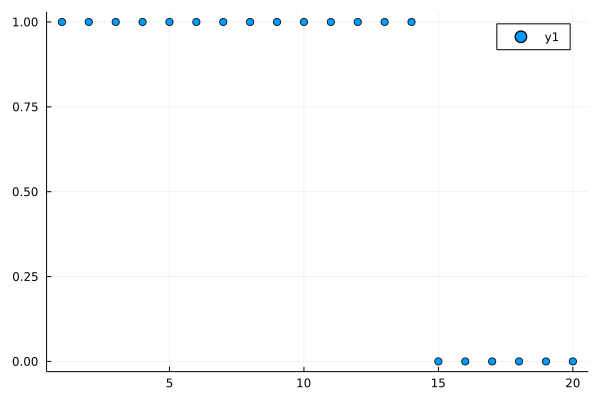

In [38]:
𝛹ₓₜ_norm=normalization_eigenstates_2D(𝛹ₓₜ,UH_1D,dΩ_1D);
scatter(𝛹ₓₜ_norm)

┌ Info: Saved animation to 
│   fn = /tmp/jl_8Jm9g5slOf.gif
└ @ Plots /home/mendez/.julia/packages/Plots/lW9ll/src/animation.jl:137


Plots.AnimatedGif("/tmp/jl_8Jm9g5slOf.gif")
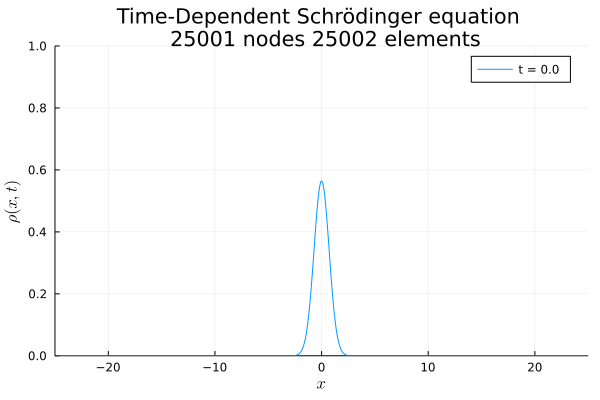

In [39]:
anim₁ = @animate for i in 1:(length(time_vec)-6)
    ρ₁Hreim_1D=real(conj(𝛹ₓₜ[i][1].(pts)).*𝛹ₓₜ[i][1].(pts)) #./ (𝛹ₓₜ_norm[i]^2)
    ρ₂Hreim_1D=real(conj(𝛹ₓₜ[i][2].(pts)).*𝛹ₓₜ[i][2].(pts)) #./ (𝛹ₓₜ_norm[i]^2)

    plot(x[:],ρ₁Hreim_1D+ρ₂Hreim_1D,label="t = $(round(time_vec[i]; digits=4))",ylim=(0,1),xlim=(-25,25))
    # plot(x[:],ρ₁Hreim_1D,label="t = $(round(time_vec[i]; digits=4))",ylim=(0,1),xlim=(-10,10))
    plot!(title="Time-Dependent Schrödinger equation \n 25001 nodes 25002 elements",xlabel="\$x\$",ylabel="\$ \\rho (x,t)\$",ylim=(0,1),xlim=(-25,25))
end

gif(anim₁, fps = 1)

### Mostramos salida de Densidad de probabilidad con visualizador Visit

<video controls width="500">
  <source src="./videos/pseudocolor_density1D_v3.mp4" type="video/mp4" />
</video>
